## Find the best neighborhood in Madrid to open a...

In [49]:
import pandas as pd
import numpy as np
import requests
import json
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
import seaborn as sns

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

In [121]:
df = pd.read_csv('barrios_municipio_madrid.csv',sep= ';', encoding='Latin 1')
df.head()

,barrio_codigo,barrio_nombre,distrito_codigo,distrito_nombre,municipio_codigo,municipio_nombre,superficie_km2,densidad_por_km2
0,796011,Palacio,79601,Centro,796,Madrid,1.46,15323.29
1,796012,Embajadores,79601,Centro,796,Madrid,1.03,43345.63
2,796013,Cortes,79601,Centro,796,Madrid,0.59,17850.85
3,796014,Justicia,79601,Centro,796,Madrid,0.75,21866.67
4,796015,Universidad,79601,Centro,796,Madrid,0.93,33051.61


In [122]:
df.columns

Index(['barrio_codigo', 'barrio_nombre', 'distrito_codigo', 'distrito_nombre',
       'municipio_codigo', 'municipio_nombre', 'superficie_km2',
       'densidad_por_km2'],
      dtype='object')

In [123]:
df.shape

(128, 8)

In [124]:
dfm=df.groupby(['distrito_codigo','distrito_nombre']).agg(','.join)
dfm.reset_index(inplace=True)
dfm.drop(['municipio_nombre'], axis=1, inplace=True)
dfm

,distrito_codigo,distrito_nombre,barrio_nombre
0,79601,Centro,"Palacio, Embajadores, Co..."
1,79602,Arganzuela,"Imperial, Las Acacias, L..."
2,79603,Retiro,"Pacífico, Adelfas, Estre..."
3,79604,Salamanca,"Recoletos, Goya, Fuente ..."
4,79605,Chamartín,"El Viso, Prosperidad, Ci..."
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ..."
6,79607,Chamberí,"Gaztambide, Arapiles, Tr..."
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ..."
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ..."
9,79610,Latina,"Los Cármenes, Puerta del Angel,..."


In [125]:
dfm.shape

(21, 3)

In [127]:
df2 = pd.read_csv('poblacion_distritos.csv',sep= ';')
df2.head()

,Distrito,Superficie (Ha),Densidad (hab./Ha),Población a 1-1-2020
0,Centro,"522,82","268,68",140.473
1,Arganzuela,"646,22",241,155.660
2,Retiro,"546,62",220,120.406
3,Salamanca,"539,24",274,147.854
4,Chamartín,"917,55",161,147.551


In [128]:
pv=pd.read_excel('precio_vivienda.xls', sheet_name=0)
pv

,Distrito,Nov_20,Oct_20,Sep_20,Ago_20,Jul_20,Jun_20,May_20,Abr_20,Mar_20,...,Sep_19,Ago_19,Jul_19,Jun_19,May_19,Abr_19,Mar_19,Feb_19,Ene_19,Renta_INE
0,Centro,4878,4909,4934,4963,4981,5061,5075,5062,5026,...,4994,4993,5044,5031,4991,5034,5069,5033,4987,16147
1,Arganzuela,3917,3908,3915,3912,3910,3948,3962,3903,3878,...,4059,4073,4096,4085,4080,4095,4071,4042,4017,17306
2,Retiro,3917,3908,3915,3912,4513,4564,4586,4560,4555,...,4572,4575,4598,4660,4669,4637,4631,4614,4529,21504
3,Salamanca,4520,5808,5826,5833,5903,5986,3962,3903,4555,...,5788,5791,5860,5868,5848,5850,5818,5829,5752,24433
4,Chamartín,5018,5040,5056,5068,5109,5180,5179,5143,5118,...,4980,4931,4941,4934,5051,5102,5174,5196,5187,25969
5,Tetuán,5018,5040,5056,3669,3682,3696,3679,3714,3725,...,3716,3719,3702,3719,3722,3731,3725,3693,3644,14970
6,Chamberí,5288,5334,5374,5329,5337,5419,5432,5426,5386,...,5331,5347,5309,5271,5287,5276,5249,5253,5285,22499
7,Fuencarral-El Pardo,3917,3908,3915,3912,4513,5986,3573,3570,3530,...,3480,3447,3436,3369,3402,3418,3379,3364,3374,18573
8,Moncloa-Aravaca,3893,3877,3913,3905,3910,3913,3898,3932,3939,...,3896,3910,3931,3928,3950,3905,3892,3875,3854,22152
9,Latina,2246,2246,2254,2269,2310,2330,2330,2364,2341,...,2292,2293,2276,2292,2290,2291,2280,2305,2303,12232


In [129]:
pv['AvgHousingPrice']=pv.mean(axis=1)
pv

,Distrito,Nov_20,Oct_20,Sep_20,Ago_20,Jul_20,Jun_20,May_20,Abr_20,Mar_20,...,Ago_19,Jul_19,Jun_19,May_19,Abr_19,Mar_19,Feb_19,Ene_19,Renta_INE,AvgHousingPrice
0,Centro,4878,4909,4934,4963,4981,5061,5075,5062,5026,...,4993,5044,5031,4991,5034,5069,5033,4987,16147,5479.500000
1,Arganzuela,3917,3908,3915,3912,3910,3948,3962,3903,3878,...,4073,4096,4085,4080,4095,4071,4042,4017,17306,4547.750000
2,Retiro,3917,3908,3915,3912,4513,4564,4586,4560,4555,...,4575,4598,4660,4669,4637,4631,4614,4529,21504,5178.416667
3,Salamanca,4520,5808,5826,5833,5903,5986,3962,3903,4555,...,5791,5860,5868,5848,5850,5818,5829,5752,24433,6352.916667
4,Chamartín,5018,5040,5056,5068,5109,5180,5179,5143,5118,...,4931,4941,4934,5051,5102,5174,5196,5187,25969,5944.666667
5,Tetuán,5018,5040,5056,3669,3682,3696,3679,3714,3725,...,3719,3702,3719,3722,3731,3725,3693,3644,14970,4333.708333
6,Chamberí,5288,5334,5374,5329,5337,5419,5432,5426,5386,...,5347,5309,5271,5287,5276,5249,5253,5285,22499,6040.750000
7,Fuencarral-El Pardo,3917,3908,3915,3912,4513,5986,3573,3570,3530,...,3447,3436,3369,3402,3418,3379,3364,3374,18573,4322.333333
8,Moncloa-Aravaca,3893,3877,3913,3905,3910,3913,3898,3932,3939,...,3910,3931,3928,3950,3905,3892,3875,3854,22152,4676.958333
9,Latina,2246,2246,2254,2269,2310,2330,2330,2364,2341,...,2293,2276,2292,2290,2291,2280,2305,2303,12232,2711.583333


In [130]:
pv.columns

Index(['Distrito', 'Nov_20', 'Oct_20', 'Sep_20', 'Ago_20', 'Jul_20', 'Jun_20',
       'May_20', 'Abr_20', 'Mar_20', 'Feb_20', 'Ene_20', 'Unnamed: 12',
       'Dic_19', 'Nov_19', 'Oct_19', 'Sep_19', 'Ago_19', 'Jul_19', 'Jun_19',
       'May_19', 'Abr_19', 'Mar_19', 'Feb_19', 'Ene_19', 'Renta_INE',
       'AvgHousingPrice'],
      dtype='object')

In [131]:
renta=pv[['Distrito','Renta_INE','AvgHousingPrice']]
renta

,Distrito,Renta_INE,AvgHousingPrice
0,Centro,16147,5479.500000
1,Arganzuela,17306,4547.750000
2,Retiro,21504,5178.416667
3,Salamanca,24433,6352.916667
4,Chamartín,25969,5944.666667
5,Tetuán,14970,4333.708333
6,Chamberí,22499,6040.750000
7,Fuencarral-El Pardo,18573,4322.333333
8,Moncloa-Aravaca,22152,4676.958333
9,Latina,12232,2711.583333


In [96]:
# Formato poblacion
#df2.style.format("{:.2f}")

In [134]:
md = dfm.join(df2['Población a 1-1-2020'])
md

,distrito_codigo,distrito_nombre,barrio_nombre,Población a 1-1-2020
0,79601,Centro,"Palacio, Embajadores, Co...",140.473
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139


In [135]:
madrid_data = md.join(renta)
madrid_data.drop('Distrito', axis=1, inplace=True)
madrid_data

,distrito_codigo,distrito_nombre,barrio_nombre,Población a 1-1-2020,Renta_INE,AvgHousingPrice
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333


In [100]:
madrid_data.shape

(21, 6)

In [136]:
madrid_data.rename(columns={'distrito_codigo': 'DistrictCode', 'distrito_nombre':'DistrictName','barrio_nombre':'Neighborhood','Población a 1-1-2020':'Population', 'Renta_INE':'RentaINE'}, inplace=True)
madrid_data

,DistrictCode,DistrictName,Neighborhood,Population,RentaINE,AvgHousingPrice
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333


In [137]:
madrid_data.describe()

,DistrictCode,Population,RentaINE,AvgHousingPrice
count,21.000000,21.000000,21.000000,21.000000
mean,79611.000000,158.796667,16078.428571,3882.521825
std,6.204837,57.538604,5046.096229,1364.257435
min,79601.000000,50.010000,9395.000000,2049.583333
25%,79606.000000,121.683000,11925.000000,2702.416667
50%,79611.000000,147.854000,15408.000000,3770.916667
75%,79616.000000,193.264000,18573.000000,4676.958333
max,79621.000000,260.196000,25969.000000,6352.916667


In [145]:
data = madrid_data.groupby('DistrictName')['Population'].sum()

In [139]:
data_per = data.groupby('DistrictName').agg(percentage =('Population', lambda p: p.sum() / data.sum() * 100)).round(2)

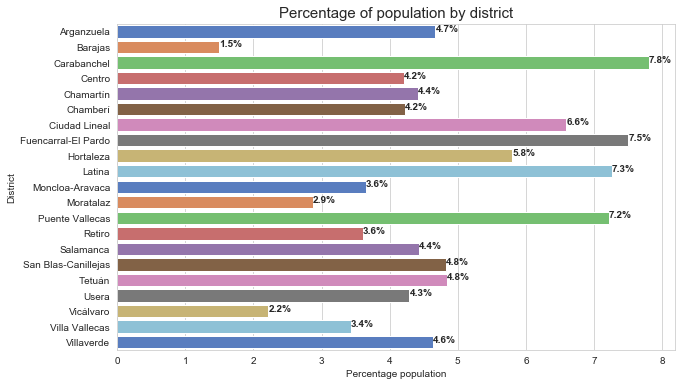

In [149]:

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x="percentage", y=data_per.index, data=data_per, ci=None, palette="muted",orient='h' )
ax.set_title("Percentage of population by district", fontsize=15)
ax.set_xlabel ("Percentage population")
ax.set_ylabel ("District")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )
bar.savefig("Seaborn_Bar_Vertical.png");

In [158]:
data2 = madrid_data.groupby('DistrictName')['RentaINE'].sum()
data_per2 = data2.groupby('DistrictName').agg(percentage =('RentaINE', lambda p: p.sum() / data2.sum() * 100)).round(2)

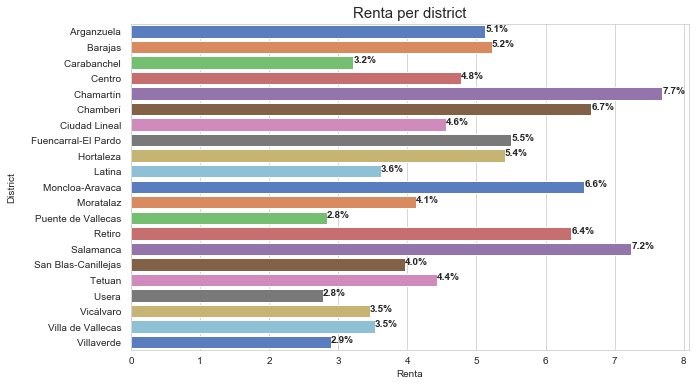

In [160]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x="percentage", y=data_per2.index, data=data_per2, ci=None, palette="muted",orient='h' )
ax.set_title("Renta per district", fontsize=15)
ax.set_xlabel ("Renta")
ax.set_ylabel ("District")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

In [162]:
data3 = madrid_data.groupby('DistrictName')['AvgHousingPrice'].sum()
data_per3 = data3.groupby('DistrictName').agg(percentage =('AvgHousingPrice', lambda p: p.sum() / data3.sum() * 100)).round(2)

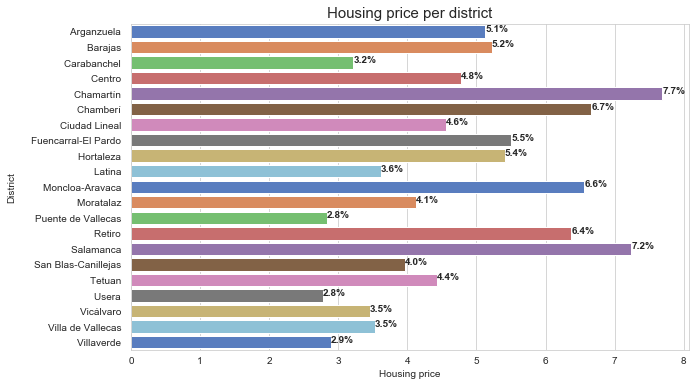

In [163]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x="percentage", y=data_per3.index, data=data_per2, ci=None, palette="muted",orient='h' )
ax.set_title("Housing price per district", fontsize=15)
ax.set_xlabel ("Housing price")
ax.set_ylabel ("District")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

In [102]:
dist_name= madrid_data['DistrictName'].tolist()
columns=['DistrictName','Latitude','Longitude']
lat_lng=pd.DataFrame(columns=columns)
for district in dist_name:
    locator=Nominatim(user_agent= 'init')
    location=locator.geocode('{}, Madrid, Spain'.format(district))
    lat=location.latitude
    lng=location.longitude
    print('District Name = {}, Latitude = {}, Longitude = {}'.format(district,location.latitude, location.longitude))
    lat_lng=lat_lng.append({'DistrictName': district, 'Latitude': lat,'Longitude':lng},ignore_index=True)
lat_lng    

District Name =     Centro , Latitude = 40.417652700000005, Longitude = -3.7079137662915533
District Name =     Arganzuela , Latitude = 40.39806845, Longitude = -3.6937339526567428
District Name =     Retiro , Latitude = 40.4111495, Longitude = -3.6760566
District Name =     Salamanca , Latitude = 40.4270451, Longitude = -3.6806024
District Name =     Chamartín , Latitude = 40.4589872, Longitude = -3.6761288
District Name =     Tetuan , Latitude = 40.4605781, Longitude = -3.6982806
District Name =     Chamberí , Latitude = 40.43624735, Longitude = -3.7038303534513837
District Name =     Fuencarral-El Pardo , Latitude = 40.55634555, Longitude = -3.7785905137518054
District Name =     Moncloa-Aravaca , Latitude = 40.43949485, Longitude = -3.7442035396547055
District Name =     Latina , Latitude = 40.4035317, Longitude = -3.736152
District Name =     Carabanchel , Latitude = 40.3742112, Longitude = -3.744676
District Name =     Usera , Latitude = 40.383894, Longitude = -3.7064459
District

,DistrictName,Latitude,Longitude
0,Centro,40.417653,-3.707914
1,Arganzuela,40.398068,-3.693734
2,Retiro,40.411150,-3.676057
3,Salamanca,40.427045,-3.680602
4,Chamartín,40.458987,-3.676129
5,Tetuan,40.460578,-3.698281
6,Chamberí,40.436247,-3.703830
7,Fuencarral-El Pardo,40.556346,-3.778591
8,Moncloa-Aravaca,40.439495,-3.744204
9,Latina,40.403532,-3.736152
